In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import edward2 as ed

In [2]:
import time
import matplotlib.pyplot as plt

RandomVariable("[4.6899657]", shape=(1,), dtype=float32, device=/job:localhost/replica:0/task:0/device:CPU:0)


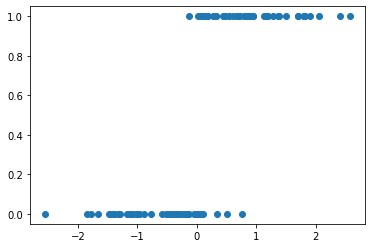

In [3]:
# sample data
def logistic_regression_data(features):
    """Bayesian logistic regression p(y | x) = int p(y | x, w, b) p(w, b) dwdb."""
    coeffs = ed.Normal(loc=5*tf.ones(features.shape[1]), scale=1., name="coeffs")
    print(coeffs)
    intercept = ed.Normal(loc=0., scale=1., name="intercept")
    outcomes = ed.Bernoulli(
      logits=tf.tensordot(features, coeffs, [[1], [0]]) + intercept,
      name="outcomes")
    return outcomes

num_features = 1
features = tf.random.normal([100, num_features])
outcomes = logistic_regression_data(features)

plt.scatter(features.numpy(), outcomes.numpy())

In [4]:
# model (prior specified here)
def logistic_regression_family(features):
    """Bayesian logistic regression p(y | x) = int p(y | x, w, b) p(w, b) dwdb."""
    w = ed.Normal(loc=tf.zeros(features.shape[1]), scale=1., name="w")
    b = ed.Normal(loc=0., scale=1., name="b")
    outcomes = ed.Bernoulli(
      logits=tf.tensordot(features, w, [[1], [0]]) + b,
      name="outcomes")
    return outcomes

In [5]:
# creates a normal distribution and trainable parameters
def build_trainable_normal(shape, name=None):
    """Builds normal r.v. and its parameters."""
    loc = tf.Variable(tf.random.normal(shape))
    scale = tf.Variable(tf.random.normal(shape))
    def normal():
        return ed.Normal(loc, tf.nn.softplus(scale), name=name)
    return normal, [loc, scale]

# creates all of the variational parameters
def build_logistic_regression_family_variational():
    """Builds posterior approximation q"""
    QW, qw_params = build_trainable_normal(shape=(features.shape[1],1), name='qw')
    QB, qb_params = build_trainable_normal(shape=(1,), name='qb')
    
    parameters = (qw_params + qb_params)
    def logistic_regression_family_variational():
        return QW(), QB()
    return logistic_regression_family_variational, parameters

In [6]:
max_steps = 5000  # number of training iterations
#model_dir = None  # directory for model checkpoints
model_dir = '.' # directory for model checkpoints

#writer = tf.summary.create_file_writer(model_dir)
[logistic_regression_family_variational, trainable_variables] = build_logistic_regression_family_variational()

optimizer = tf.keras.optimizers.Adam(1e-3)

#@tf.function
def train_step(outcomes, step):
    with tf.GradientTape() as tape:
        # Compute expected log-likelihood. First, sample from the variational
        # distribution; second, compute the log-likelihood given the sample.
        qw, qb = logistic_regression_family_variational()

        # Compute forward pass of model, setting value of the priors to the
        # approximate posterior samples. We also record the forward pass' execution
        # via ed.tape().
        with ed.tape() as model_tape:
            with ed.condition(w=qw, b=qb):
                posterior_predictive = logistic_regression_family(features)

        log_likelihood = posterior_predictive.distribution.log_prob(outcomes)

        # Compute analytic KL-divergence between variational and prior distributions.
        kl = 0.
        for rv_name, variational_rv in [("w", qw), ("b", qb)]:
            kl += tf.reduce_sum(variational_rv.distribution.kl_divergence(
                model_tape[rv_name].distribution))

        elbo = tf.reduce_mean(log_likelihood - kl)
        #with writer.default():
        #    tf.summary.scalar("elbo", elbo, step=step)
        #    loss = -elbo
        loss = -elbo
    #optimizer = tf.keras.optimizers.Adam(1e-3)
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

for step in range(max_steps):
    start_time = time.time()
    loss = train_step(outcomes, step)
    if step % 500 == 0:
        #writer.flush()
        duration = time.time() - start_time
        print("Step: {:>3d} Loss: {:.3f} ({:.3f} sec)".format(
            step, loss, duration))
        

Step:   0 Loss: 2.301 (0.022 sec)
Step: 500 Loss: 1.258 (0.024 sec)
Step: 1000 Loss: 0.978 (0.010 sec)
Step: 1500 Loss: 0.819 (0.011 sec)
Step: 2000 Loss: 0.966 (0.011 sec)
Step: 2500 Loss: 1.037 (0.010 sec)
Step: 3000 Loss: 1.054 (0.010 sec)
Step: 3500 Loss: 0.924 (0.010 sec)
Step: 4000 Loss: 1.074 (0.029 sec)
Step: 4500 Loss: 0.848 (0.011 sec)


In [7]:
sigmoid = lambda z: (1+np.exp(-z))**(-1)

In [8]:
n_samp = 100
n_grid = 100
features_pred = tf.reshape(tf.linspace(-3.0,3.0,n_grid), (-1,1))
p1_samp = np.zeros((n_samp, n_grid))
for i in range(n_samp):
    qw, qb = logistic_regression_family_variational()
    with ed.condition(w=qw, b=qb):
        f = tf.tensordot(features_pred, qw, [[1], [0]]) + qb
        p1_samp[i,:] = sigmoid(f.numpy()).reshape(1,-1)


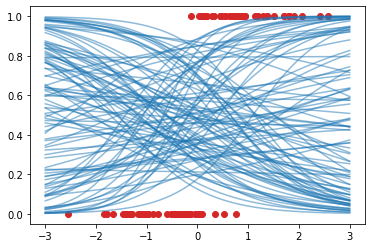

In [9]:
_=plt.plot(features_pred.numpy(), p1_samp.T, color='tab:blue', alpha=.5)
plt.scatter(features.numpy(), outcomes.numpy(), color='tab:red')